In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import StackingRegressor, StackingClassifier, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

In [3]:
file_path = '/Users/skylarp/Desktop/spambase/spambase.data'
names_file_path = '/Users/skylarp/Desktop/spambase/spambase.names'

In [4]:
with open(names_file_path, 'r') as f:
    lines = f.readlines()[33:]
    column_names = [line.split(':')[0] for line in lines if line.strip() and not line.startswith('|')]
    column_names.append('label')

In [5]:
data = pd.read_csv(file_path, header=None,names=column_names)

In [6]:
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Data Preprocessing

In [7]:
#Train-Test Split
from sklearn.model_selection import train_test_split

X = data.drop('label', axis=1)  
y = data['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train.columns]
X_test.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test.columns]

### Model Selection

In [8]:
#Nested CV
inner_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
outer_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
#Hyperparameter tuning (Grid Search)

In [10]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
means score 0.9992526812381235


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

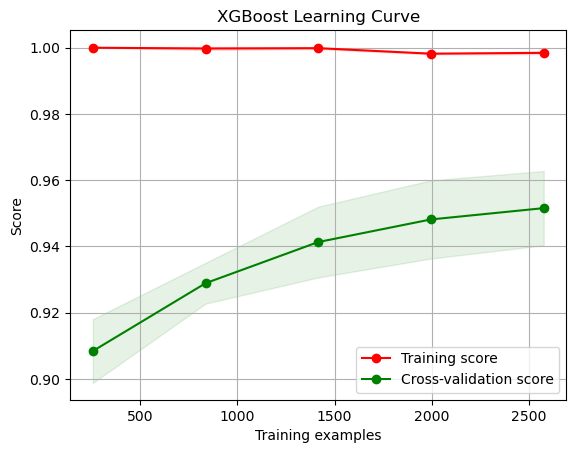

In [11]:
#XGBoost
xgb_model = XGBClassifier()

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=inner_kfold)
grid_search_xgb.fit(X_train, y_train)

best_params_xgb = grid_search_xgb.best_params_

print("Best Parameters for XGBoost:", best_params_xgb)

train_sizes, train_scores, test_scores = learning_curve(grid_search_xgb.best_estimator_, X_train, y_train, 
                                                        cv=outer_kfold)
print('means score',np.mean(train_scores))
plot_learning_curve(train_sizes, train_scores, test_scores, title="XGBoost Learning Curve")

Best Parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
means score 0.9998577278781164


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

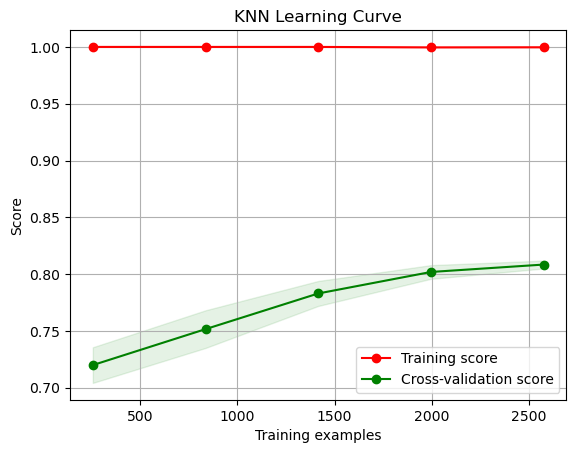

In [12]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(knn_model, param_grid=param_grid_knn, cv=inner_kfold)
grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_

print("Best Parameters for KNN:", best_params_knn)

train_sizes, train_scores, test_scores = learning_curve(grid_search_knn.best_estimator_, X_train, y_train, cv=outer_kfold)
print('means score',np.mean(train_scores))
plot_learning_curve(train_sizes, train_scores, test_scores, title="KNN Learning Curve")

Best Parameters for SVM: {'C': 10}
means score 0.7311595225953705


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

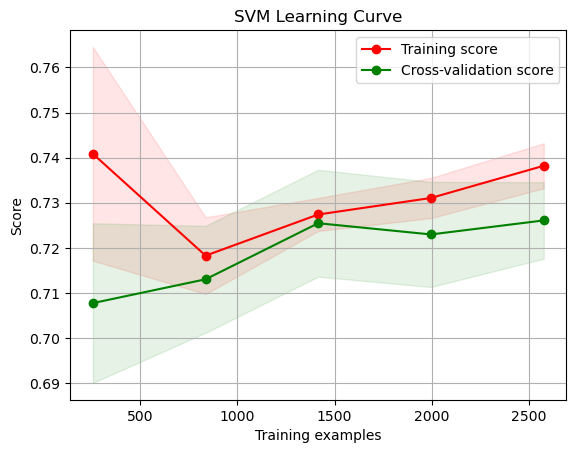

In [13]:
#SVM
from sklearn.svm import SVC

svm_model = SVC()

param_grid_svm = {
    'C': [0.1, 1, 10]
#     'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(svm_model, param_grid=param_grid_svm, cv=inner_kfold)
grid_search_svm.fit(X_train, y_train)

best_params_svm = grid_search_svm.best_params_

print("Best Parameters for SVM:", best_params_svm)

train_sizes, train_scores, test_scores = learning_curve(grid_search_svm.best_estimator_, X_train, y_train, cv=outer_kfold)
print('means score',np.mean(train_scores))
plot_learning_curve(train_sizes, train_scores, test_scores, title="SVM Learning Curve")

Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
means score 0.9250019936610845


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

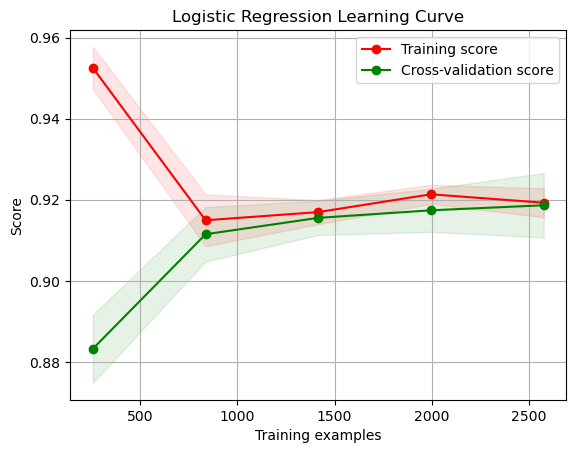

In [14]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search_lr = GridSearchCV(lr_model, param_grid=param_grid_lr, cv=inner_kfold)
grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_

print("Best Parameters for Logistic Regression:", best_params_lr)

train_sizes, train_scores, test_scores = learning_curve(grid_search_lr.best_estimator_, X_train, y_train, cv=outer_kfold)
print('means score',np.mean(train_scores))
plot_learning_curve(train_sizes, train_scores, test_scores, title="Logistic Regression Learning Curve")

### Normalization

In [15]:
#Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. XGBoost
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy (Not Scaled):", accuracy_xgb)

xgb_model_scaled = XGBClassifier(**best_params_xgb)
xgb_model_scaled.fit(X_train_scaled, y_train)
y_pred_xgb_scaled = xgb_model_scaled.predict(X_test_scaled)
accuracy_xgb_scaled = accuracy_score(y_test, y_pred_xgb_scaled)
print("XGBoost Accuracy (Scaled):", accuracy_xgb_scaled)

# 2. KNN
knn_model = KNeighborsClassifier(**best_params_knn)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy (Not Scaled):", accuracy_knn)

knn_model_scaled = KNeighborsClassifier(**best_params_knn)
knn_model_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_model_scaled.predict(X_test_scaled)
accuracy_knn_scaled = accuracy_score(y_test, y_pred_knn_scaled)
print("KNN Accuracy (Scaled):", accuracy_knn_scaled)

# 3. SVM
svm_model = SVC(**best_params_svm)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy (Not Scaled):", accuracy_svm)

svm_model_scaled = SVC(**best_params_svm)
svm_model_scaled.fit(X_train_scaled, y_train)
y_pred_svm_scaled = svm_model_scaled.predict(X_test_scaled)
accuracy_svm_scaled = accuracy_score(y_test, y_pred_svm_scaled)
print("SVM Accuracy (Scaled):", accuracy_svm_scaled)

# 4. Logistic Regression
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy (Not Scaled):", accuracy_lr)

lr_model_scaled = LogisticRegression(**best_params_lr)
lr_model_scaled.fit(X_train_scaled, y_train)
y_pred_lr_scaled = lr_model_scaled.predict(X_test_scaled)
accuracy_lr_scaled = accuracy_score(y_test, y_pred_lr_scaled)
print("Logistic Regression Accuracy (Scaled):", accuracy_lr_scaled)

XGBoost Accuracy (Not Scaled): 0.9551049963794352
XGBoost Accuracy (Scaled): 0.9551049963794352
KNN Accuracy (Not Scaled): 0.7979724837074583
KNN Accuracy (Scaled): 0.9015206372194062
SVM Accuracy (Not Scaled): 0.7277335264301231
SVM Accuracy (Scaled): 0.939898624185373
Logistic Regression Accuracy (Not Scaled): 0.9268645908761767
Logistic Regression Accuracy (Scaled): 0.9232440260680667


## Model(i): Optimal model with Maximized Predictive Accuracy

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Hyperparameter Tuning
xgb_model_scaled = XGBClassifier(**best_params_xgb)

#Fit the model
xgb_model_scaled.fit(X_train_scaled, y_train)
y_pred_xgb_scaled = xgb_model_scaled.predict(X_test_scaled)

#Evaluation 
accuracy_xgb_scaled = accuracy_score(y_test, y_pred_xgb_scaled)
precision_xgb_scaled = precision_score(y_test, y_pred_xgb_scaled)
recall_xgb_scaled = recall_score(y_test, y_pred_xgb_scaled)
f1_xgb_scaled = f1_score(y_test, y_pred_xgb_scaled)

print("XGBoost Performance (Scaled):")
print("Accuracy:", accuracy_xgb_scaled)
print("Precision:", precision_xgb_scaled)
print("Recall:", recall_xgb_scaled)
print("F1 Score:", f1_xgb_scaled)
print(confusion_matrix(y_test, y_pred_xgb_scaled))
print(classification_report(y_test, y_pred_xgb_scaled))

XGBoost Performance (Scaled):
Accuracy: 0.9551049963794352
Precision: 0.9462738301559792
Recall: 0.9462738301559792
F1 Score: 0.9462738301559792
[[773  31]
 [ 31 546]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       804
           1       0.95      0.95      0.95       577

    accuracy                           0.96      1381
   macro avg       0.95      0.95      0.95      1381
weighted avg       0.96      0.96      0.96      1381



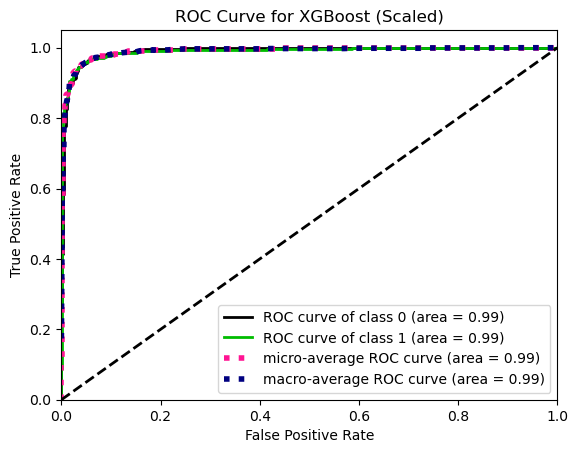

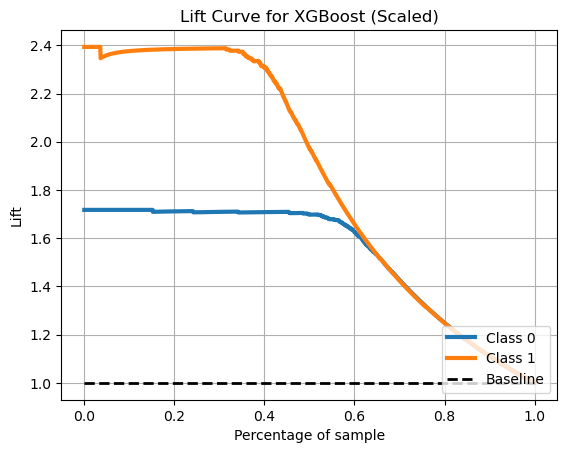

In [17]:
# Predict probabilities
prob = xgb_model_scaled.predict_proba(X_test_scaled)

# Plot ROC curve
skplt.metrics.plot_roc(y_test, prob)
plt.title("ROC Curve for XGBoost (Scaled)")
plt.show()

# Plot Lift curve
skplt.metrics.plot_lift_curve(y_test, prob)
plt.title("Lift Curve for XGBoost (Scaled)")
plt.show()

## Model(ii): Cost-sensitive Classification Model

### Misclassification Cost

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def cost_sensitive_evaluation(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    cost_true_positive = cm[1, 1] * 0  
    cost_true_negative = cm[0, 0] * 0  
    cost_false_positive = cm[0, 1] * 10
    cost_false_negative = cm[1, 0] * 1
    
    total_cost = cost_true_positive + cost_true_negative + cost_false_positive + cost_false_negative
    
    return total_cost

In [19]:
cost_sensitive_scorer = make_scorer(cost_sensitive_evaluation, greater_is_better=False)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
# 1. XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}
grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid=param_grid_xgb, scoring=cost_sensitive_scorer, cv=kfold)
grid_search_xgb.fit(X_train, y_train)

# Cost
best_params_xgb = grid_search_xgb.best_params_
total_cost_xgb = cost_sensitive_evaluation(y_test, grid_search_xgb.predict(X_test))
print("XGBoost - Best Parameters:", best_params_xgb)
print("XGBoost - Total Cost on Test Set:", total_cost_xgb)

XGBoost - Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
XGBoost - Total Cost on Test Set: 287


In [21]:
# 2. KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, scoring=cost_sensitive_scorer, cv=kfold)
grid_search_knn.fit(X_train, y_train)

# Cost
best_params_knn = grid_search_knn.best_params_
total_cost_knn = cost_sensitive_evaluation(y_test, grid_search_knn.predict(X_test))
print("KNN - Best Parameters:", best_params_knn)
print("KNN - Total Cost on Test Set:", total_cost_knn)

KNN - Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
KNN - Total Cost on Test Set: 1450


In [22]:
# 3. SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf']
}
grid_search_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, scoring=cost_sensitive_scorer, cv=kfold)
grid_search_svm.fit(X_train, y_train)

# Cost
best_params_svm = grid_search_svm.best_params_
total_cost_svm = cost_sensitive_evaluation(y_test, grid_search_svm.predict(X_test))
print("SVM - Best Parameters:", best_params_svm)
print("SVM - Total Cost on Test Set:", total_cost_svm)

SVM - Best Parameters: {'C': 10}
SVM - Total Cost on Test Set: 1051


In [24]:
# 4. Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid_lr, scoring=cost_sensitive_scorer, cv=kfold)
grid_search_lr.fit(X_train, y_train)

# Cost
best_params_lr = grid_search_lr.best_params_
total_cost_lr = cost_sensitive_evaluation(y_test, grid_search_lr.predict(X_test))
print("Logistic Regression - Best Parameters:", best_params_lr)
print("Logistic Regression - Total Cost on Test Set:", total_cost_lr)

Logistic Regression - Best Parameters: {'C': 1, 'penalty': 'l2'}
Logistic Regression - Total Cost on Test Set: 506


Therefore, XGBoost performs best.